# Easy21 Assignment

In [1]:
import gymnasium as gym
import numpy as np
import itertools
import easy21_env
from matplotlib import pyplot as plt
import matplotlib

# set up the gym environment
env = gym.make("easy21_env:Easy21-v0", render_mode=None)

## Part 2: Monte-Carlo Control

In [2]:
episodes = 1000000
q_fxn = np.zeros(shape=(22+1,10+1,2)) # action-value function: player_total, dealer_total, action
visit_count = np.zeros(shape=(22+1,10+1,2)) # number of times state-action pairs have been visited: player_total, dealer_total, action
for i_episode in range(episodes):
    if i_episode % (episodes/10) == 0:
        print(f"Running episode {i_episode}...")
    visits_this_episode = np.zeros(shape=(22+1,10+1,2))
    state, _ = env.reset()
    episode_reward = 0
    for i_step in itertools.count():
        # choose action with epsilon-greedy policy
        if np.random.random() > 100/(100+np.sum(visit_count[state[0], state[1]])):
            action = np.argmax(q_fxn[state[0], state[1]])
        else:
            action = np.random.randint(1+1)
        
        # update visit count
        visits_this_episode[state[0], state[1], action] += 1

        # move on to next step
        state, reward, terminated, truncated, _ = env.step(action)
        state = np.clip(state, a_min=0, a_max=22)
        episode_reward += reward
        if terminated or truncated:
            break
        
    # update action-value function at end of episode
    visit_count += visits_this_episode
    q_fxn[visits_this_episode > 0] += (1/visit_count * (episode_reward - q_fxn))[visits_this_episode > 0]

Running episode 0...


C:\Users\brand\AppData\Local\Temp\ipykernel_33800\856434689.py:29: RuntimeWarning: divide by zero encountered in divide
  q_fxn[visits_this_episode > 0] += (1/visit_count * (episode_reward - q_fxn))[visits_this_episode > 0]
C:\Users\brand\AppData\Local\Temp\ipykernel_33800\856434689.py:29: RuntimeWarning: invalid value encountered in multiply
  q_fxn[visits_this_episode > 0] += (1/visit_count * (episode_reward - q_fxn))[visits_this_episode > 0]


Running episode 100000...
Running episode 200000...
Running episode 300000...
Running episode 400000...
Running episode 500000...
Running episode 600000...
Running episode 700000...
Running episode 800000...
Running episode 900000...


Text(0.5, 0, 'Value')

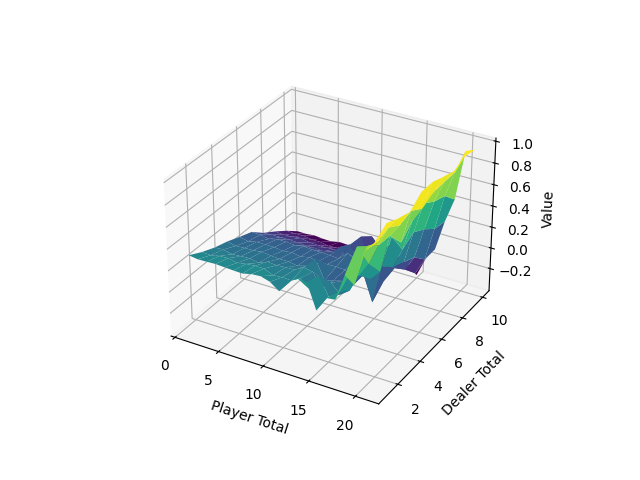

In [3]:
v_fxn = np.amax(q_fxn, axis=2)

%matplotlib widget
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
Y,X = np.meshgrid(np.arange(1,10+1), np.arange(1,22))
ax.plot_surface(X,Y,v_fxn[1:22,1:], cmap=matplotlib.cm.viridis)
ax.set_xlabel("Player Total")
ax.set_ylabel("Dealer Total")
ax.set_zlabel("Value")

## Part 3: TD Learning

In [4]:
q_fxn_montecarlo = q_fxn

In [24]:
# takes lmda, episodes
# returns q_fxn, mse_seq
def sarsa_training(lmda, episodes=1000):
    q_fxn = np.zeros(shape=(22+1,11+1,2)) # action-value function: player_total, dealer_total, action
    visit_count = np.zeros(shape=(22+1,11+1,2))
    mse_seq = np.zeros(episodes)

    for i_episode in range(episodes):
        eligibility_trace = np.zeros(shape=(22+1,11+1,2))
        state, _ = env.reset()
        for i_step in itertools.count():
            # choose action with epsilon-greedy policy
            if np.random.random() > 100/(100+np.sum(visit_count[state[0], state[1]])):
                action = np.argmax(q_fxn[state[0], state[1]])
            else:
                action = np.random.randint(1+1)

            # update visit count, eligibility trace
            visit_count[state[0], state[1], action] += 1
            eligibility_trace[state[0], state[1], action] += 1
            
            # take a step, then update the q_fxn
            next_state, reward, terminated, truncated, _ = env.step(action)
            next_state[0] = np.clip(next_state[0], a_min=0, a_max=22)
            next_state[1] = np.clip(next_state[1], a_min=0, a_max=11)

            # update q_fxn, eligibility_trace
            delta = reward + np.max(q_fxn[next_state[0], next_state[1]]) - q_fxn[state[0], state[1], action]
            q_fxn += 1/visit_count[state[0], state[1], action] * delta * eligibility_trace
            eligibility_trace *= lmda

            # move to the next step
            state = next_state
            if terminated or truncated:
                break
        
        # record mse
        mse_seq[i_episode] = np.mean((q_fxn[:,:11,:] - q_fxn_montecarlo)**2)
    
    return q_fxn, mse_seq

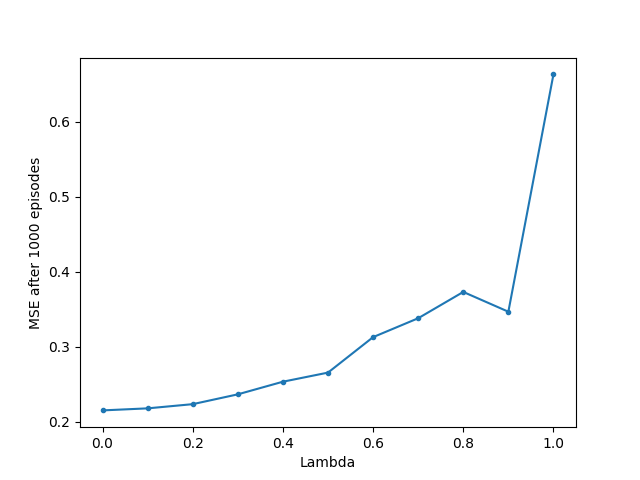

In [25]:
lmdas = np.linspace(0, 1, 11)
mse_vs_lmbda = np.zeros(11)
for i_lmda in range(11):
    mse_vs_lmbda[i_lmda] = sarsa_training(lmdas[i_lmda], episodes=1000)[1][-1]

plt.figure()
plt.plot(lmdas, mse_vs_lmbda, ".-")
plt.xlabel("Lambda")
plt.ylabel("MSE after 1000 episodes")
plt.show()

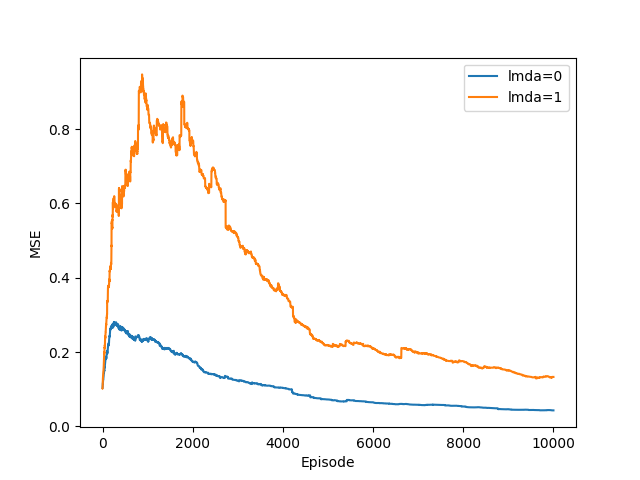

In [26]:
episodes = 10000
plt.figure()

plt.plot(np.arange(episodes), sarsa_training(0, episodes)[1], label="lmda=0")
plt.plot(np.arange(episodes), sarsa_training(1, episodes)[1], label="lmda=1")

plt.xlabel("Episode")
plt.ylabel("MSE")
plt.legend()
plt.show()

## Part 4: Linear Function Approximation

In [2]:
# takes lmda, episodes
# runs sarsa(lambda) with linear function approximation
# returns q_fxn, episode_rewards

def choose_action(q_params, epsilon, state):
    if np.random.random() > epsilon:
        return 0 if np.sum(q_params * as_features(state, 0)) > np.sum(q_params * as_features(state, 1)) else 1
    else:
        return np.random.randint(2)

def as_features(state, action):
    dealer_ints = np.array([[1,4], [4,7], [7,10]])
    player_ints = np.array([[1,6], [4,9], [7,12], [10,15], [13,18], [16,21]])

    in_dealer_ints = ((state[0] >= dealer_ints[:,0]) * (state[0] <= dealer_ints[:,1]))[:,None] # 3x1 matrix
    in_player_ints = ((state[1] >= player_ints[:,0]) * (state[1] <= player_ints[:,1]))[:,None] # 1x6 matrix
    return (in_dealer_ints @ in_player_ints.T)[:,:,None] @ np.array([action==0, action==1])[:,None].T

def linear_sarsa(lmda=0, episodes=1000):
    q_params = np.zeros(shape=(3,6,2))
    episode_rewards = np.zeros(episodes)

    for i_episode in range(episodes):
        # reset eligibility_trace, state, action
        eligibility_trace = np.zeros(shape=(3,6,2))
        state, _ = env.reset()
        action = choose_action(q_params, 0.05, state)

        for i_step in itertools.count():
            # take a step, find the next action
            next_state, reward, terminated, truncated, _ = env.step(action)
            next_action = choose_action(q_params, 0.05, next_state)
            episode_rewards[i_episode] += reward

            # find the td error
            if terminated or truncated:
                delta = reward - np.sum(q_params * as_features(state, action))
            else:
                delta = reward + np.sum(q_params * as_features(next_state, next_action)) - np.sum(q_params * as_features(state, action))

            # update the q_fxn and eligibility traces according to sarsa(lmda)
            eligibility_trace += as_features(state, action)
            q_params += 0.01 * delta * eligibility_trace
            eligibility_trace *= lmda

            # move on to the next state; break if terminated
            state = next_state
            action = next_action
            if terminated or truncated: break
    
    return q_params, episode_rewards

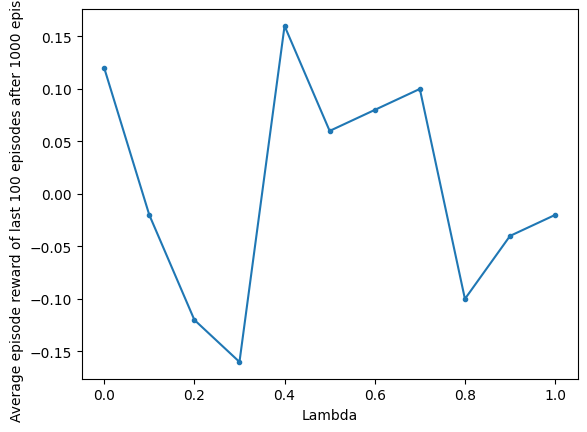

In [3]:
lmdas = np.linspace(0, 1, 11)
mse_vs_lmbda = np.zeros(11)
for i_lmda in range(11):
    mse_vs_lmbda[i_lmda] = np.mean(linear_sarsa(lmdas[i_lmda], episodes=10000)[1][-100:])

plt.figure()
plt.plot(lmdas, mse_vs_lmbda, ".-")
plt.xlabel("Lambda")
plt.ylabel("Average episode reward of last 100 episodes after 1000 episodes")
plt.show()

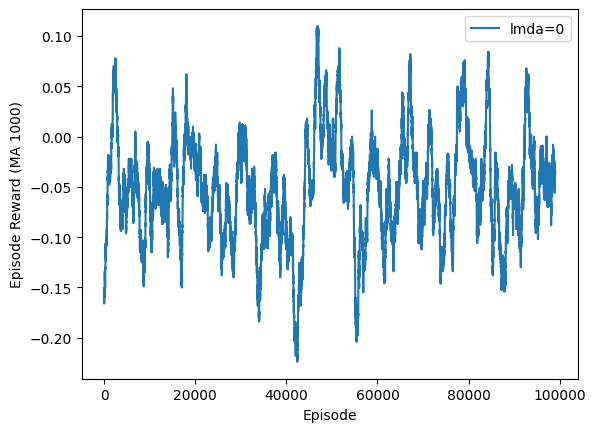

In [7]:
episodes = 100000
ma_range = episodes/100
plt.figure()

episode_rewards = linear_sarsa(0.3, episodes)[1]
plt.plot(
    np.arange(episodes-ma_range),
    [np.mean(episode_rewards[i:i+ma_range]) for i in range(episodes-ma_range)],
    label="lmda=0"
)

plt.xlabel("Episode")
plt.ylabel(f"Episode Reward (MA {ma_range})")
plt.legend()
plt.show()